<a href="https://colab.research.google.com/github/EloraApple/TidyTues/blob/main/TidyTuesdayW16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

daily_accidents = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-04-22/daily_accidents.csv', parse_dates=['date'])
daily_accidents_420 = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-04-22/daily_accidents_420.csv', parse_dates=['date'])


daily_accidents_420.head() #check data


,date,e420,fatalities_count
0,1992-01-01,False,144
1,1992-01-02,False,111
2,1992-01-07,False,85
3,1992-01-12,False,127
4,1992-01-03,False,182


In [2]:
#add Day of the Week to data sets
daily_accidents["day_of_week"] = daily_accidents["date"].dt.day_name()
daily_accidents_420["day_of_week"] = daily_accidents_420["date"].dt.day_name()
daily_accidents_420.head() #check data

,date,e420,fatalities_count,day_of_week
0,1992-01-01,False,144,Wednesday
1,1992-01-02,False,111,Thursday
2,1992-01-07,False,85,Tuesday
3,1992-01-12,False,127,Sunday
4,1992-01-03,False,182,Friday


In [3]:
#ensure date is a datetime object
daily_accidents["date"] = pd.to_datetime(daily_accidents["date"])

#get min and max date
start_date = daily_accidents["date"].min()
end_date = daily_accidents["date"].max()

print("Date range:", start_date.date(), "to", end_date.date()) #confirm data date range

Date range: 1992-01-01 to 2016-12-31


<ipython-input-4-01429bab1ff5>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_by_day.index, y=avg_by_day.values,


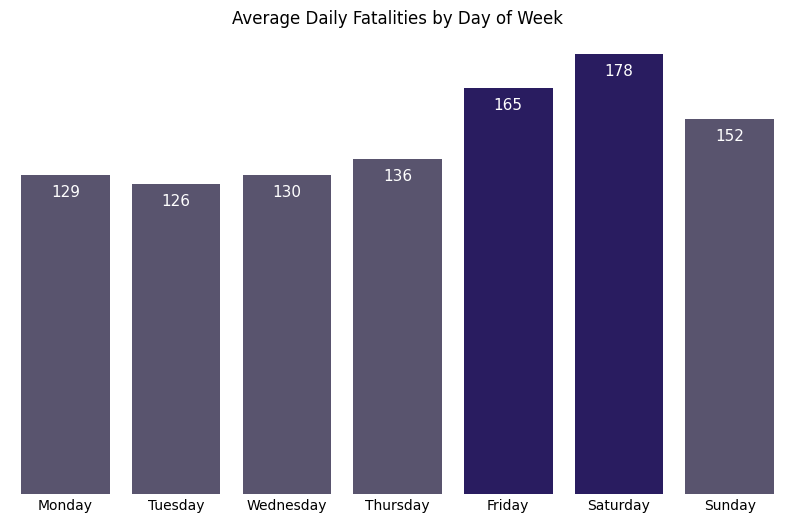

In [4]:
#build first bar graph

#average fatalities by day of the week
avg_by_day = (
    daily_accidents.groupby("day_of_week")["fatalities_count"]
    .mean()
    .reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
)

#get the top 2 highest values (days) to highlight trend that weekends havethe highest fatality rate
top_2_days = avg_by_day.sort_values(ascending=False).head(2).index.tolist()

#set custom colors: one for base, another for top 2
colors = [
    "#564f73" if day not in top_2_days else "#22116b"
    for day in avg_by_day.index
]

#plot figure
plt.figure(figsize=(10,6))
sns.barplot(x=avg_by_day.index, y=avg_by_day.values,
    palette=colors)
plt.title("Average Daily Fatalities by Day of Week")

#add values inside each bar
for i, (day, value) in enumerate(zip(avg_by_day.index, avg_by_day.values)):
    plt.text(
        i,               # x position (bar index)
        value - 7,       # y position (halfway up the bar)
        f"{value:.0f}",  # label (1 decimal place)
        ha='center',     # horizontal alignment
        va='center',     # vertical alignment
        color='white',   # text color
        fontsize=11
    )

#formatting
plt.xticks(rotation=0)
plt.xlabel("")
plt.tick_params(axis='x', length=0)  # Removes x-axis ticks
plt.tick_params(axis='y', length=0)  # Removes y-axis ticks
plt.gca().axes.get_yaxis().set_visible(False)
sns.despine(left=True, bottom=True)

plt.show()

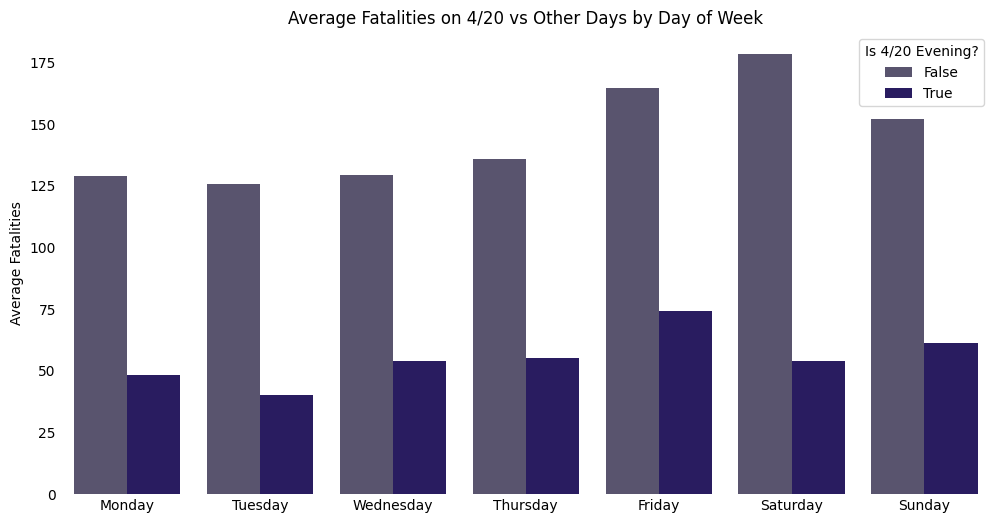

In [5]:
#create second bar chart

#group by wether or not the accident took place on 4/20
grouped = (
    daily_accidents_420
    .groupby(["e420", "day_of_week"])["fatalities_count"]
    .mean()
    .reset_index()
)

#ensure days of week are in order and grouped
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
grouped["day_of_week"] = pd.Categorical(grouped["day_of_week"], categories=day_order, ordered=True)
grouped = grouped.sort_values(["e420", "day_of_week"])

#plot figure and formatting
plt.figure(figsize=(12, 6))
sns.barplot(
    data=grouped,
    x="day_of_week",
    y="fatalities_count",
    hue="e420",
    palette=["#564f73", "#22116b"]
)

plt.title("Average Fatalities on 4/20 vs Other Days by Day of Week")
plt.ylabel("Average Fatalities")
plt.xlabel("")  # remove x-axis label
plt.tick_params(axis='x', length=0)  # Removes x-axis ticks
plt.tick_params(axis='y', length=0)  # Removes y-axis ticks
plt.legend(title="Is 4/20 Evening?")
plt.xticks(rotation=0)
sns.despine(left=True, bottom=True)

plt.show()

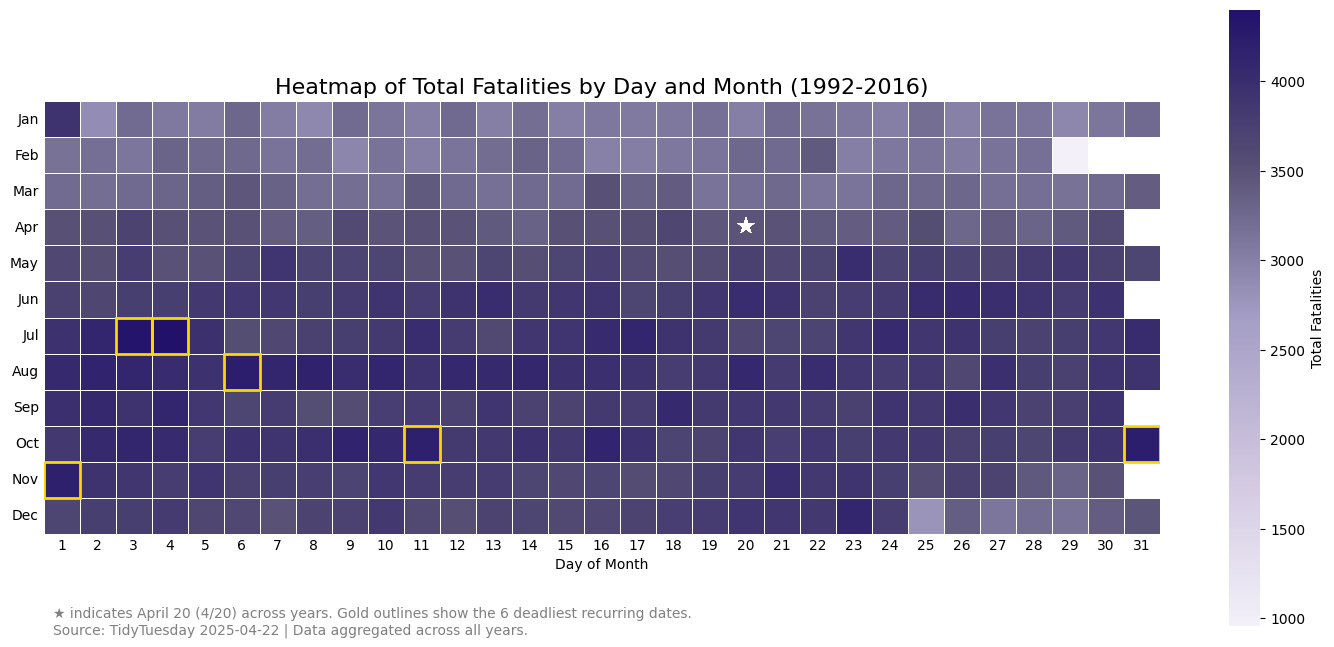

In [6]:
#create heatmap

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle

#set color pallette to match above graphs
custom_colors = ["#f3f0f9", "#d0c6e0", "#a49dc5", "#564f73", "#22116b"]
custom_cmap = LinearSegmentedColormap.from_list("fatality_palette", custom_colors)

#add month and day columns
df = daily_accidents.copy()
df["month"] = df["date"].dt.strftime('%b')       # abbreviated month name
df["day"] = df["date"].dt.day                    # numeric day (1–31)
df["month_order"] = df["date"].dt.month          # numeric month for sorting

#group by month and day
summary = df.groupby(["month", "month_order", "day"])["fatalities_count"].sum().reset_index()

#pivot to get matrix: rows = month, cols = day
pivot = summary.pivot(index="month", columns="day", values="fatalities_count")

#sort months in calendar order
pivot = pivot.loc[["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]]

#top 6 highest fatality days (across all years)
#was originally 5 but the top 6 days provided a clearer impact of crashes on the days after a major holiday (inlcuded Nov 1)
top6_days = (
    df.groupby(["month", "day"])["fatalities_count"]
    .sum()
    .reset_index()
    .sort_values("fatalities_count", ascending=False)
    .head(6)
)


#April 20s (across years)
april_20s = df[(df["date"].dt.month == 4) & (df["date"].dt.day == 20)]

#plot figure
plt.figure(figsize=(18, 8))
ax=sns.heatmap(
    pivot,
    cmap=custom_cmap,
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'Total Fatalities'},
    square=True
)

plt.title("Heatmap of Total Fatalities by Day and Month (1992-2016)", fontsize=16)
plt.xlabel("Day of Month")
plt.ylabel("")
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.tick_params(axis='x', length=0)  # Removes x-axis ticks
plt.tick_params(axis='y', length=0)  # Removes y-axis ticks

#helper to get row (month) index in heatmap
month_lookup = {month: i for i, month in enumerate(pivot.index)}

#draw outlines around top 6 days
for _, row in top6_days.iterrows():
    month = row["month"]
    day = row["day"]
    row_i = month_lookup.get(month)
    col_j = day - 1  # adjust for 0-based indexing
    if pd.notnull(row_i):
        rect = Rectangle(
            (col_j, row_i), 1, 1,
            fill=False, edgecolor='gold', linewidth=2
        )
        ax.add_patch(rect)

#add star on April 20
for _, row in april_20s.iterrows():
    month = row["month"]
    day = row["day"]
    row_i = month_lookup.get(month)
    col_j = day - 1
    if pd.notnull(row_i):
        ax.text(
            col_j + 0.5, row_i + 0.5,
            "★",
            ha='center', va='center',
            fontsize=16,
            color='white',
            fontweight='bold'
        )

#add footnote
plt.figtext(
    .13, .1,
    "★ indicates April 20 (4/20) across years. Gold outlines show the 6 deadliest recurring dates.\nSource: TidyTuesday 2025-04-22 | Data aggregated across all years.",
    wrap=False,
    horizontalalignment='left',
    fontsize=10,
    color='gray'
)

plt.show()


In [7]:
#wasn't used in report, but helped me review top days for possible trends
top6_days = (
    df.groupby(["month", "day"])["fatalities_count"]
    .sum()
    .reset_index()
    .sort_values("fatalities_count", ascending=False)
    .head(6)
)
print(top6_days)

    month  day  fatalities_count
155   Jul    4              4400
154   Jul    3              4350
335   Oct   31              4216
35    Aug    6              4213
315   Oct   11              4188
275   Nov    1              4185
